In [1]:
#version vx3

## new to this version
# optimize lr

## already incode
# selected features 11
# STD>3 train entry removed
# keras.layers.merge.Concatenate(axis=-1)

## already tried
# 

## other options
# optimizers, batch size, 
# dropout layer, batchnorm, dense (layers/nuron per) numbers

## future
# remove column with <.2 variance
# try individual feature then try combinations

In [2]:
#0.40094 <- 
#0.39138 <- # real,elim std>3, # 12-300-30-10-1 # test_vx1 #epoch 60/200 0s - loss: 0.3677 - val_loss: 0.2493
#0.40566 <- # real,elim std>3, # 12-300-30-10-1 # test_v1_ext #epoch 72/200 0s - loss: 0.5543 - val_loss: 0.2496
#0.48500 <- elim std>3, 12-300-30-10-1
#0.52512 <- Epoch 11/200  16s - loss: 0.4993 - val_loss: 0.3509
#0.38798 <- 12-300-30-5-1
#0.41785<- 9col grp1 loss: 0.3123 - acc: 0.0000e+00 - val_loss: 0.2602
#0.43247 <-3col 
#0.53085 <- adadelta
#0.50647 <-decay
#0.48978 <-rmsle

#task
# feature extraction
# feature selection
# optimizaer selection , lr , decay

In [3]:
### importing libraries
%matplotlib inline
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Convolution1D
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import SGD,RMSprop
from keras.datasets import mnist
from keras.layers import Concatenate,Merge
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

import matplotlib as mpl

#mpl.use('Agg')
import matplotlib.pyplot as plt
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)

Using TensorFlow backend.


20170505-211827


In [4]:
def load_data():
    df_train = pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
    df_test = pd.read_csv("../input/test.csv", parse_dates=['timestamp'])
    df_macro = pd.read_csv("../input/macro.csv", parse_dates=['timestamp'])
    return [df_train,df_test,df_macro]
#df_train.head()

In [5]:
#print( df_train.shape)

In [6]:
#selected features

#gr1=["full_sq", "life_sq", "floor", "max_floor", "material", 
#"build_year","num_room", "kitch_sq","state","radiation_km",
#"green_zone_km","railroad_km", "public_transport_station_km","metro_min_avto" ] 
#"kindergarden_km" 
#"sub_area" = object, str

#gr1=["full_sq"] #elbo 10 epo  26/200 0s - loss: 0.3472 - val_loss: 0.2767
#gr1=["life_sq"] #     20 epo 163/200 0s - loss: 0.4144 - val_loss: 0.3150
#gr1=["floor"]   #     55 epo  83/200 0s - loss: 0.4261 - val_loss: 0.3554


#gr1 = list(set(gr1))
#print(len(gr1))
#for c in gr1:
#    print (c+"\t"+str(df_train[c].dtype))

1


NameError: name 'df_train' is not defined

In [8]:
# This section added:  drop crazy data point
def drop_crazy_data_point(clist,df_train):
    '''drop_crazy_data_point, STD>3
    clist = columnlist to use
    df_train = pandas dataframe
    '''
    
    #clist = gr1#['life_sq','floor']
    for cname in clist:
        df_train.drop(df_train[ np.abs((df_train[cname]-df_train[cname].mean())/df_train[cname].std())>3].index, inplace=True)
    print('shape after drop_crazy_data_point:')
    print( df_train.shape)
    return df_train
    

In [9]:
def take_ytrain_testid_traincnt(df_train,df_test):
    y_train = df_train['price_doc'].values
    id_test = df_test['id']

    df_train.drop(['id', 'price_doc'], axis=1, inplace=True)
    df_test.drop(['id'], axis=1, inplace=True)

    num_train = len(df_train)
    df_all = pd.concat([df_train, df_test])
    df_all = df_all.join(df_macro, on='timestamp', rsuffix='_macro')
    print(df_all.shape)
    

    # Add month-year
    month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
    month_year_cnt_map = month_year.value_counts().to_dict()
    df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

    # Add week-year count
    week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
    week_year_cnt_map = week_year.value_counts().to_dict()
    df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

    # Add month and day-of-week
    df_all['month'] = df_all.timestamp.dt.month
    df_all['dow'] = df_all.timestamp.dt.dayofweek

    # Other feature engineering
    #df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
    #df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)

    # Remove timestamp column (may overfit the model in train)
    df_all.drop(['timestamp', 'timestamp_macro'], axis=1, inplace=True)

    return [y_train,id_test,num_train,df_all]


In [10]:
def factor(df_all,num_train,gr1,gr2):
    factorize = lambda t: pd.factorize(t[1])[0]

    df_obj = df_all.select_dtypes(include=['object'])

    X_all = np.c_[
        df_all.select_dtypes(exclude=['object']).values,
        np.array(list(map(factorize, df_obj.iteritems()))).T
    ]
    print(X_all.shape)

    X_train = X_all[:num_train]
    X_test = X_all[num_train:]

    # Deal with categorical values
    df_numeric = df_all.select_dtypes(exclude=['object'])
    df_obj = df_all.select_dtypes(include=['object']).copy()

    for c in df_obj:
        df_obj[c] = pd.factorize(df_obj[c])[0]

    df_values = pd.concat([df_numeric, df_obj], axis=1)

    df_values=df_values.fillna(df_values.mean())
    df_values=df_values.dropna(axis="columns", how='all')

    #df_values.drop(['area_m','ID_metro'], axis=1, inplace=True)

    
    df_values1=df_values[gr1]
    df_values2=df_values[gr2]
    
    #df_values.mean()
    #df_values.shape
    
    # Convert to numpy values
    X_all1 = df_values1.values
    X_all2 = df_values2.values
    #print(X_all1.shape)

    X_train1 = X_all1[:num_train]
    X_train2 = X_all2[:num_train]
    
    X_test1 = X_all1[num_train:]
    X_test2 = X_all2[num_train:]

    #df_columns = df_values.columns.tolist
    #df_columns

    return [X_train1,X_train2,X_test1,X_test2]

In [11]:
#for c in df_values.columns:
#    if df_values[c].dtype == 'object':
#        lbl = preprocessing.LabelEncoder()
#        lbl.fit(list(df_values[c].values)) 
#        df_values[c] = lbl.transform(list(df_values[c].values))

In [12]:
#c = df_values.columns[4]
#df_values[c]
#c

In [13]:
#X_all.tofile("x_all.csv",format="%s",sep=",")

In [14]:
#df_valuesclean=df_values.dropna(axis="columns", how='any')
#df_valuesclean.shape

In [15]:
from keras.layers.merge import Concatenate
# define base model
def baseline_model(df_values1_cols,df_values2_cols):
    
    model1 = Sequential()
    model1.add(Dense(30, input_dim=df_values1_cols, activation='relu'))
    #model1.add(BatchNormalization())
    #model1.add(Dropout(0.5))
    #model1.add(Dense(60,activation="relu"))
    #model1.add(Dropout(0.25))
    model1.add(Dense(15,activation="relu"))
    #model1.add(Dropout(0.25))
    
    model2 = Sequential()
    model2.add(Dense(30, input_dim=df_values2_cols, activation='relu'))
    #model1.add(BatchNormalization())
    #model2.add(Dropout(0.5))
    #model2.add(Dense(60,activation="relu"))
    #model2.add(Dropout(0.5))
    model2.add(Dense(15,activation="relu"))
    #model2.add(Dropout(0.25))
    
    model = Sequential()
    #model.add(Concatenate([model1, model2],input_shape=(120,1)))
    model.add(Merge([model1, model2], mode='concat'))
    model.add(Dense(100,activation="relu"))
    #model.add(Dropout(0.25))
    model.add(Dense(30,activation="relu"))
    model.add(Dense(1,activation="relu"))
    # Compile model
    #sgd=SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    
    
    
#     RMSProp optimizer.

# It is recommended to leave the parameters of this optimizer at their default values (except the learning rate, which can be freely tuned).

# This optimizer is usually a good choice for recurrent neural networks.

# Arguments

# lr: float >= 0. Learning rate.
# rho: float >= 0.
# epsilon: float >= 0. Fuzz factor.
# decay: float >= 0. Learning rate decay over each update
    
    #default optimizer
    #model.compile(loss='mean_squared_logarithmic_error', \
    #              optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0))
    
    #lowering lr
    model.compile(loss='mean_squared_logarithmic_error', \
                  optimizer=RMSprop(lr=0.00001, rho=0.9, epsilon=1e-08, decay=0.0))
    
    #my model
    #model.compile(loss='mean_squared_logarithmic_error', optimizer=RMSprop(decay=0.0001))
        #Adadelta
        #sgd
    return [model1,model2,model]

In [35]:
[df_train,df_test,df_macro]=load_data()

In [36]:
[model1,model2,model]=baseline_model(15,15)
model1.summary()
model2.summary()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 30)                480       
_________________________________________________________________
dense_16 (Dense)             (None, 15)                465       
Total params: 945
Trainable params: 945
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 30)                480       
_________________________________________________________________
dense_18 (Dense)             (None, 15)                465       
Total params: 945
Trainable params: 945
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)  

/home/minesh/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [24]:
def trainKeras(model,X_train1,X_train2,y_train,epo):
#model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
    print ("^^^INFO: Fit Model^^^")
#X_train = X_train.reshape(X_train.shape[0],244,1)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=50, verbose=2)
    ]

    history = model.fit(x=[X_train1,X_train2],y= y_train, epochs=epo, batch_size=780, validation_split=0.3, verbose=2)#,callbacks=callbacks) #verbose=2 )#
    return [model,history]

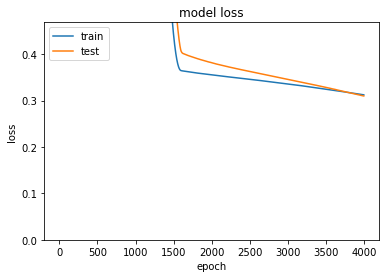

In [19]:
# list all data in history
'''
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# axes = plt.gca()
# axes.set_xlim([0,120])
# axes.set_ylim([90,100])
#plt.savefig('acc.png')  # save the figure to file
plt.show()
#plt.close()
'''


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('loss.png')
#plt.show()

plt.ylim([0, \
          min(history.history['loss'])+min(history.history['loss'])/2])
plt.show()

#plt.fig()
#plt.close()

In [30]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('multipage_pdf.pdf') as pdf:
    for i in range(0,10):
    # summarize history for loss
        plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')

        plt.ylim([0, 2])
        #plt.show()
        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()

NameError: name 'history' is not defined

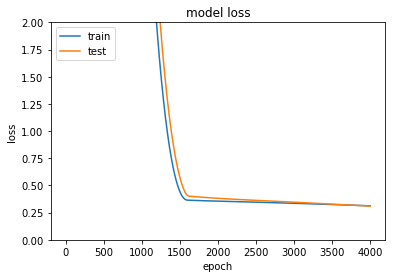

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.ylim([0, 2])
plt.show()

In [32]:
filePath="myfile.txt"

In [17]:
def writeToFile(history,filePath,columns):
    fh=open(filePath,'a')
    loss=history.history['loss']
    loss_diff=np.diff(loss)
    val_loss=history.history['val_loss']
    val_loss_diff=np.diff(val_loss)

    loss_Elbow=min(list((x for x in range(0,len(loss_diff.tolist())) if loss_diff.tolist()[x] > -0.01)))+1
    val_loss_Elbow=min(list((x for x in range(0,len(val_loss_diff.tolist())) if val_loss_diff.tolist()[x] > -0.01)))+1

    print(','.join(columns),"\tlE",loss_Elbow,"\tvlE",val_loss_Elbow,"\ttepo",len(history.history['loss']),end='',file=fh)
    print("\tloss\t{0:0.5f}".format(history.history['loss'][-1]),"\tval_loss\t{0:0.5f}".format(history.history['val_loss'][-1]),file=fh)


In [34]:
writeToFile(history,filePath,columns=['1','2'])

NameError: name 'history' is not defined

In [35]:

#print("loss\t{0:0.5f}".format(history.history['loss'][-1]),"\tval_loss\t{0:0.5f}".format(history.history['val_loss'][-1]))

#print("%0.3f \tval_loss\t %0.5f " % history.history['loss'][-1],history.history['val_loss'][-1])

In [ ]:
#looping for features
gr4=["full_sq", "life_sq", "floor", "max_floor", "material", 
"build_year","num_room", "kitch_sq","state","radiation_km"]
gr3 =["green_zone_km","railroad_km", "public_transport_station_km","metro_min_avto" ] 

gr1=["num_room", "life_sq", "metro_min_walk", "nuclear_reactor_km", "ttk_km", "zd_vokzaly_avto_km", "sadovoe_km", "bulvar_ring_km", "kremlin_km", "stadium_km"]
gr2=["basketball_km", "ID_railroad_station_walk", "build_count_slag", "build_count_panel", "prom_part_3000", "build_count_frame",
     "build_count_before_1920", "indust_part", "raion_build_count_with_material_info",
     "build_count_1971-1995"]

gr1=gr1+gr2+gr3+gr4
gr2=["life_sq", "big_church_km", "metro_km_walk", "public_healthcare_km", "kremlin_km",
     "fitness_km", "market_shop_km", "basketball_km", "zd_vokzaly_avto_km", 
     "green_part_1500"]

clist=gr1+gr2
print("--------->",clist)
print("=> loading data:")
[df_train,df_test,df_macro]=load_data()
print("=> drop_crazy_data_point:")
df_train=drop_crazy_data_point(clist,df_train)
print("=> prepare data:")
[y_train,id_test,num_train,df_all]=take_ytrain_testid_traincnt(df_train,df_test)
print('=> handle factors')
[X_train1,X_train2,X_test1,X_test2]=factor(df_all,num_train,gr1,gr2)
print('=> model arch')
[model1,model2,model]=baseline_model(X_train1.shape[1],X_train2.shape[1])
print('=> train')
[model,history]=trainKeras(model,X_train1,X_train2,y_train,epo=7000)
print('=>print to file')
writeToFile(history,filePath="try1_concat_lr.txt",columns=clist)
    

---------> ['num_room', 'life_sq', 'metro_min_walk', 'nuclear_reactor_km', 'ttk_km', 'zd_vokzaly_avto_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'stadium_km', 'basketball_km', 'ID_railroad_station_walk', 'build_count_slag', 'build_count_panel', 'prom_part_3000', 'build_count_frame', 'build_count_before_1920', 'indust_part', 'raion_build_count_with_material_info', 'build_count_1971-1995', 'green_zone_km', 'railroad_km', 'public_transport_station_km', 'metro_min_avto', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'radiation_km', 'life_sq', 'big_church_km', 'metro_km_walk', 'public_healthcare_km', 'kremlin_km', 'fitness_km', 'market_shop_km', 'basketball_km', 'zd_vokzaly_avto_km', 'green_part_1500']
=> loading data:
=> drop_crazy_data_point:
shape after drop_crazy_data_point:
(21836, 292)
=> prepare data:
(29498, 390)
=> handle factors
(29498, 392)
=> model arch
=> train
^^^INFO: Fit Model^^^


/home/minesh/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Train on 15285 samples, validate on 6551 samples
Epoch 1/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 2/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 3/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 4/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 5/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 6/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 7/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 8/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 9/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 10/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 11/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 12/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 13/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 14/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 15/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 16/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 17/7000
0s - loss: 243.4148 - val_loss: 248.3149
Epoch 18/7000
0s - loss: 

In [48]:
X_train

array([[ 43.        ,  27.        ,   4.        , ...,   1.30515949,
          0.27498514,   2.5902411 ],
       [ 34.        ,  19.        ,   3.        , ...,   0.69453573,
          0.06526334,   0.93669973],
       [ 43.        ,  29.        ,   2.        , ...,   0.70069112,
          0.32875604,   2.1209989 ],
       ..., 
       [ 45.        ,  32.99267568,  10.        , ...,   1.72722333,
          0.63001355,   2.15279162],
       [ 64.        ,  32.        ,   5.        , ...,   4.89804719,
          0.26152751,   3.37781368],
       [ 43.        ,  28.        ,   1.        , ...,   0.7349489 ,
          0.25015115,   0.58463601]])

In [34]:
#X_test = X_test.reshape(X_test.shape[0],244,1)

In [21]:
y_test=model.predict([X_test1,X_test2])

In [22]:
y_test[:,0].shape

(7662,)

In [23]:
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_test[:,0]})

df_sub.to_csv('sub 2017-04-30_rmsle_vx3_lr_4000epo.csv', index=False) 

# 0.49433
# Epoch 4000/4000
# 0s - loss: 0.3124 - val_loss: 0.3100


#0.40908
#120/120
#0s - loss: 0.2793 - val_loss: 0.2215




In [ ]:
submitreal 12 elimstd>3 #0.40566